In [1]:
import torch
import gc

# Clear CUDA cache
torch.cuda.empty_cache()
# Clear memory
gc.collect()

# Restart kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [2]:
# Automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from EDA import *
from data_preprocessing import *
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from unet_model import *
from loss import *
import torch.optim as optim
from torchsummary import summary


In [4]:
# Define output directory for saving test plots
OUTPUT_DIR = "visualizations/test_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
#project_dir = os.path.dirname(os.path.abspath(__file__))
project_dir = os.getcwd() 
data_path = os.path.join(project_dir, "data")
print(data_path)

# EDA - image sizes, top text descriptions, sample data
run_eda(data_path)

# Split data into train, val and test
split_data(data_path)



/home/cc/MMI_Unet_Lesion_Segmentation/data
Saved: visualizations/eda_outputs/top_descriptions.png
Saved: visualizations/eda_outputs/image_sizes.png
Saved: visualizations/eda_outputs/sample_visualizations.png
Data split completed: 2183 training, 273 validation, 273 testing.


In [6]:
# Preprocess the data - Resize and Augmentation
train_transforms = A.Compose([
    
    A.RandomScale(scale_limit=0.1, p=0.1),  # 10% zoom
    A.Resize(224, 224),
    ToTensorV2() #convert to tensor and normalize
])

val_test_transforms = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()   
])

train_dataset = SegmentationDataset(data_path, "train", transform=train_transforms)
val_dataset = SegmentationDataset(data_path, "val", transform=val_test_transforms) 
test_dataset = SegmentationDataset(data_path, "test",transform=val_test_transforms) 

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")



Number of training samples: 2183
Number of validation samples: 273
Number of testing samples: 273


In [7]:
BATCH_SIZE = 1
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [8]:
for images, masks, text_descriptions in train_loader:
    print(f"Image type: {type(images)}")
    print(f"Image shape: {images.shape}")
    print(f"Image data type: {images.dtype}") 
    
    print(f"Text description type: {type(text_descriptions)}")

    print(f"Mask type: {type(masks)}")
    print(f"Mask shape: {masks.shape}")
    print(f"Mask data type: {masks.dtype}")


    break

Image type: <class 'torch.Tensor'>
Image shape: torch.Size([1, 3, 224, 224])
Image data type: torch.float32
Text description type: <class 'tuple'>
Mask type: <class 'torch.Tensor'>
Mask shape: torch.Size([1, 1, 224, 224])
Mask data type: torch.float32


In [9]:
from torchinfo import summary
from mmi_unet_model import MMI_UNet
import torch

model = MMI_UNet(out_channels=1)

summary(model)

Layer (type:depth-idx)                                                 Param #
MMI_UNet                                                               --
├─ConvNeXtEncoder: 1-1                                                 --
│    └─ConvNextModel: 2-1                                              --
│    │    └─ConvNextEmbeddings: 3-1                                    4,896
│    │    └─ConvNextEncoder: 3-2                                       27,813,696
│    │    └─LayerNorm: 3-3                                             1,536
│    └─ConvNextStage: 2-2                                              (recursive)
│    │    └─Identity: 3-4                                              --
│    │    └─Sequential: 3-5                                            (recursive)
│    └─ConvNextStage: 2-3                                              (recursive)
│    │    └─Sequential: 3-6                                            (recursive)
│    │    └─Sequential: 3-7                              

In [10]:
images = torch.randn(1, 3, 224, 224)  
reports = [
"Bilateral pulmonary infection, two infected areas, all left lung and middle right lung."
]

# The model handles the text encoding internally
segmentation_maps = model(images, reports)

In [11]:
print(segmentation_maps)

tensor([[[[0.4601, 0.6083, 0.4440,  ..., 0.5538, 0.4350, 0.5456],
          [0.4608, 0.4809, 0.4915,  ..., 0.4084, 0.4499, 0.4844],
          [0.4795, 0.5906, 0.4572,  ..., 0.5155, 0.6321, 0.6288],
          ...,
          [0.3638, 0.3964, 0.4891,  ..., 0.3813, 0.4200, 0.5645],
          [0.5526, 0.5909, 0.5046,  ..., 0.5184, 0.5014, 0.5620],
          [0.4181, 0.4157, 0.4776,  ..., 0.4602, 0.4798, 0.5385]]]],
       grad_fn=<SigmoidBackward0>)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
from loss import *
from train import *
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = MMI_UNet(out_channels=1).to(device)

# Loss and optimizer
criterion = CombinedLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Train the model
train(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10], Batch [1/2183] - Loss: 1.9725
Epoch [1/10], Batch [501/2183] - Loss: 1.8191
Epoch [1/10], Batch [1001/2183] - Loss: 1.8018
Epoch [1/10], Batch [1501/2183] - Loss: 1.7900
Epoch [1/10], Batch [2001/2183] - Loss: 1.7627
Epoch 1/10 - Train Loss: 1.7813, Dice: 0.0116, IoU: 0.0059, 
Val Loss: 1.7488, Dice: 0.0930, IoU: 0.0470
Epoch [2/10], Batch [1/2183] - Loss: 1.7251
Epoch [2/10], Batch [501/2183] - Loss: 1.7556
Epoch [2/10], Batch [1001/2183] - Loss: 1.7512
Epoch [2/10], Batch [1501/2183] - Loss: 1.7509
Epoch [2/10], Batch [2001/2183] - Loss: 1.7350
Epoch 2/10 - Train Loss: 1.7287, Dice: 0.1468, IoU: 0.0956, 
Val Loss: 1.7083, Dice: 1.1740, IoU: 0.7648
Epoch [3/10], Batch [1/2183] - Loss: 1.6999
Epoch [3/10], Batch [501/2183] - Loss: 1.5596
Epoch [3/10], Batch [1001/2183] - Loss: 1.7336
Epoch [3/10], Batch [1501/2183] - Loss: 1.7300
Epoch [3/10], Batch [2001/2183] - Loss: 1.6481
Epoch 3/10 - Train Loss: 1.6997, Dice: 0.2841, IoU: 0.1920, 
Val Loss: 1.6888, Dice: 2.2717, IoU:

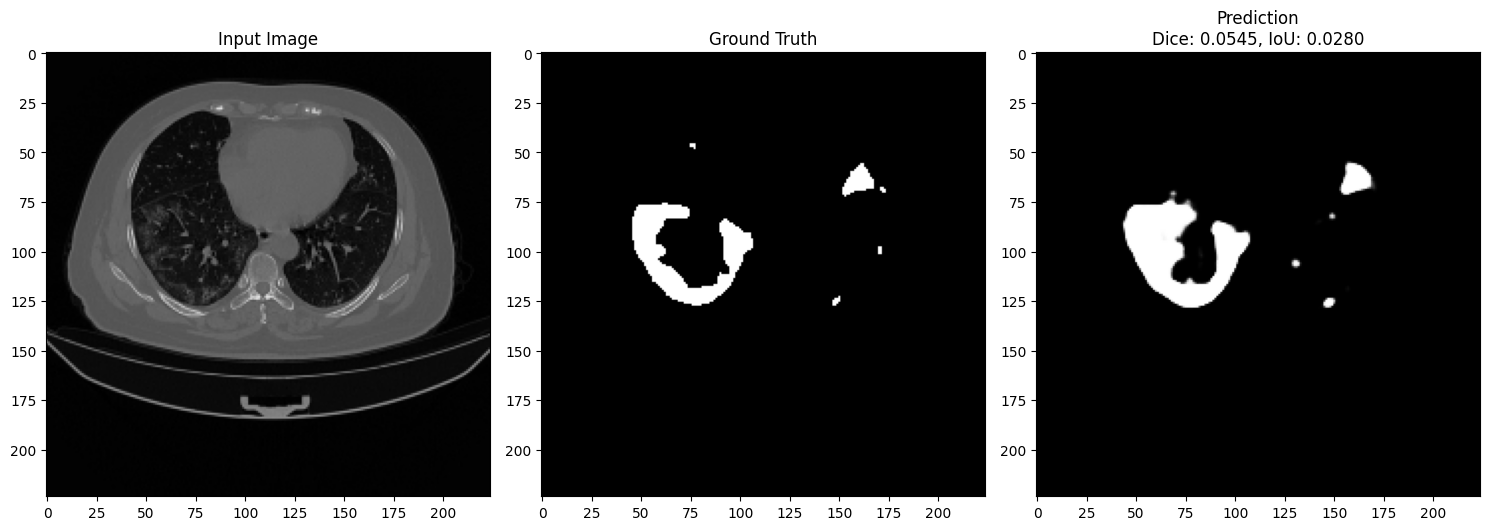

Saved: visualizations/test_outputs/test_case_0.png


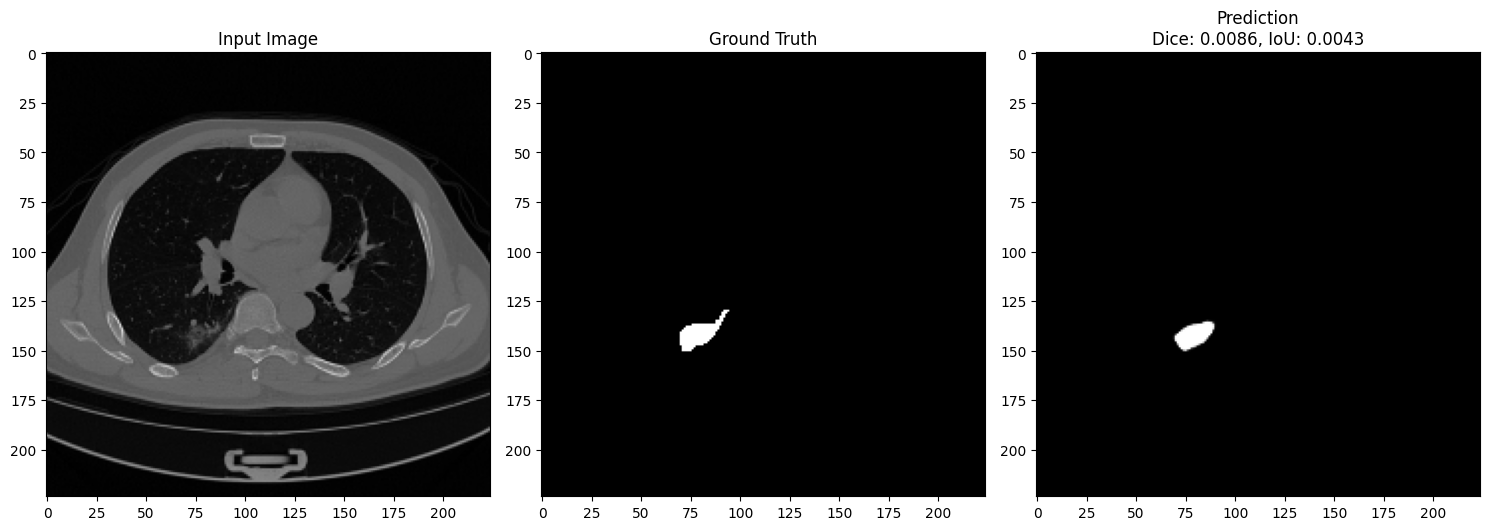

Saved: visualizations/test_outputs/test_case_1.png


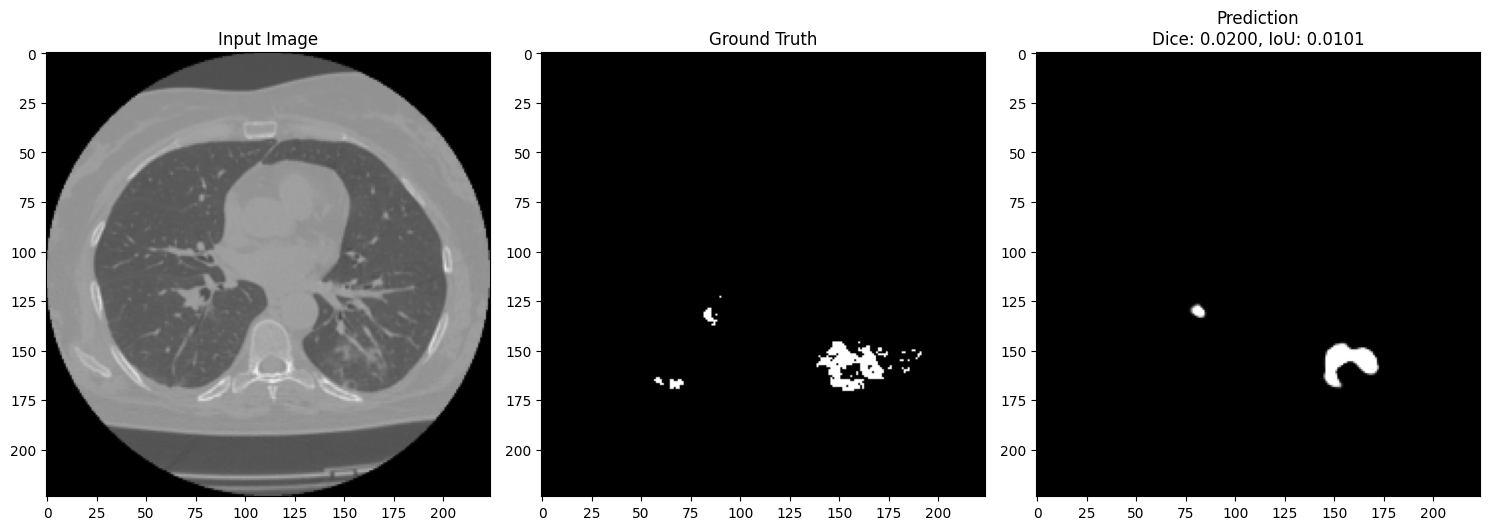

Saved: visualizations/test_outputs/test_case_2.png


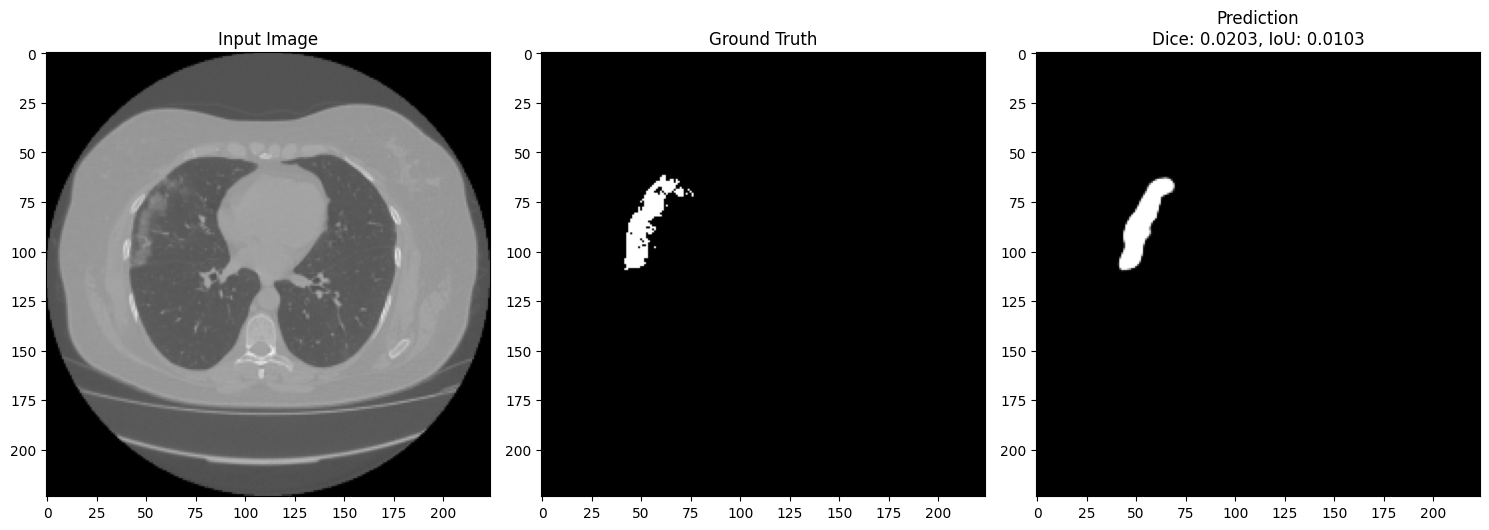

Saved: visualizations/test_outputs/test_case_3.png


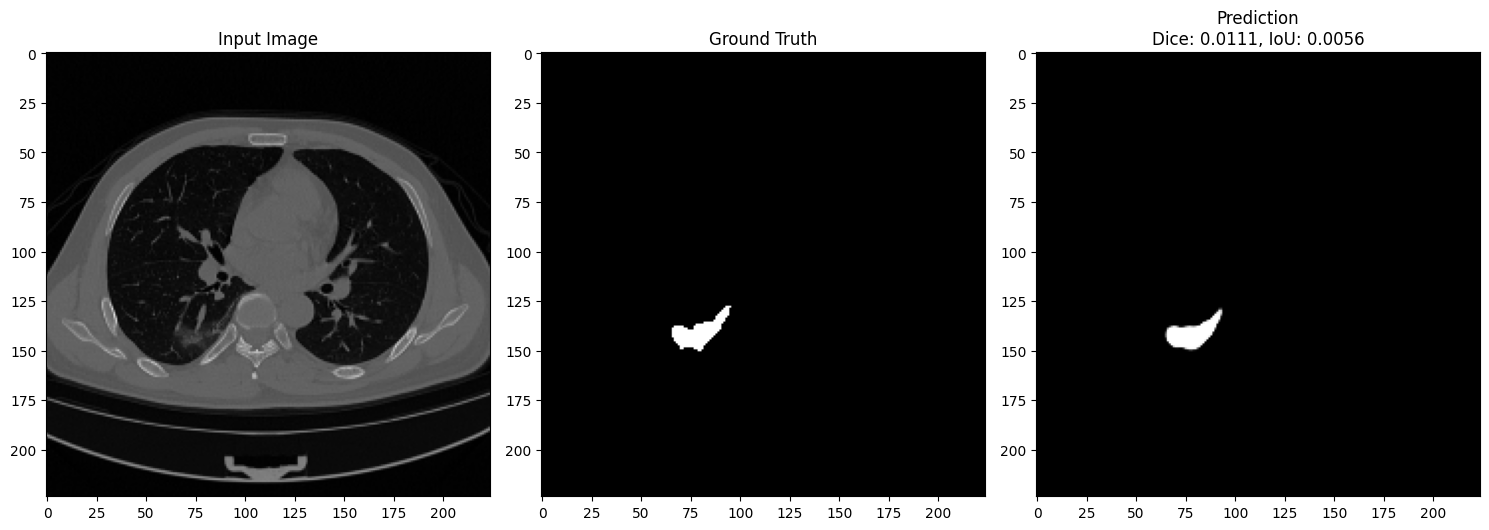

Saved: visualizations/test_outputs/test_case_4.png
Test Dice Score: 0.0287
Test IoU Score: 0.0151


In [16]:
model.eval()
total_dice, total_iou, num_samples = 0, 0, 0

with torch.no_grad():
    for i, (image, mask, text) in enumerate(test_loader):
        # Model computations on GPU
        image, mask = image.to(device), mask.to(device)
        pred = model(image, text)
        pred = torch.sigmoid(pred)

        # Metrics computation on GPU
        dice = dice_score(pred, mask).item()
        iou = iou_score(pred, mask).item()
        total_dice += dice
        total_iou += iou
        num_samples += 1

        # Visualization - need to move to CPU for matplotlib
        if i < 5:  
            plt.figure(figsize=(15, 5))
            
            # Move to CPU only for visualization
            img_display = image.cpu()[0].permute(1, 2, 0).numpy()
            mask_display = mask.cpu()[0].squeeze().numpy()
            pred_display = pred.cpu()[0].squeeze().numpy()
            
            plt.subplot(1, 3, 1)
            plt.imshow(img_display)
            plt.title("Input Image")
            
            plt.subplot(1, 3, 2)
            plt.imshow(mask_display, cmap="gray")
            plt.title("Ground Truth")
            
            plt.subplot(1, 3, 3)
            plt.imshow(pred_display, cmap="gray")
            plt.title(f"Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}")
            
            plt.tight_layout()
            plt.show()
            plot_path = os.path.join(OUTPUT_DIR, f"test_case_{i}.png")
            plt.savefig(plot_path, bbox_inches="tight")
            plt.close()
    
            print(f"Saved: {plot_path}")

print(f"Test Dice Score: {total_dice / num_samples:.4f}")
print(f"Test IoU Score: {total_iou / num_samples:.4f}")